In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image
from IPython.display import display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/ukraine-ml-bootcamp-2023
/kaggle/input/ukraine-ml-bootcamp-2023/images
/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images
/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images


**Data**

In [13]:
project_path = '/kaggle/input/ukraine-ml-bootcamp-2023/'
url_train = '/kaggle/input/ukraine-ml-bootcamp-2023/train.csv'
url_test = '/kaggle/input/ukraine-ml-bootcamp-2023/test.csv'
url_base = '/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/'

df = pd.read_csv(url_train)
# image size
#df['image_size'] = df['image_id'].apply(lambda x: Image.open(url_base+x).size)
df

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0
...,...,...
2355,3cb75d7569544a8be6850893dc939ed6.jpg,4
2356,fa14b6703b1eda25b4a851c163a1efc2.jpg,5
2357,e58ee6afa09efc6021e8b56a9bda6960.jpg,0
2358,94c16216e9674ec1a254c73d56d2ebe1.jpg,2


Classes Distribution

<Axes: title={'center': 'Classes distribution'}>

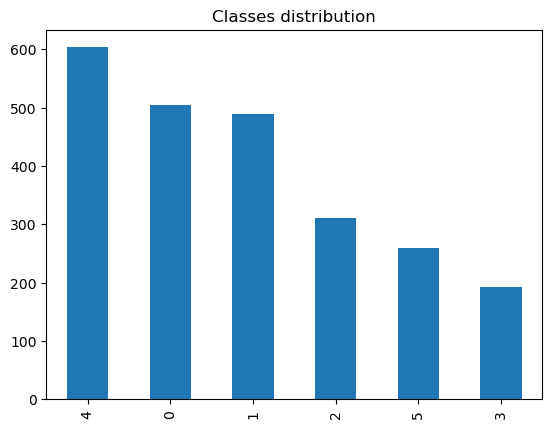

In [14]:
df['class_6'].value_counts().plot(kind='bar', title='Classes distribution')

Random Images from Dataset

In [15]:
number_random_images = 4
df_class = df.groupby('class_6')['image_id'].apply(set).reset_index()
df_class['num'] = df_class['image_id'].apply(len)
df_class['image_random'] = df_class['image_id'].apply(lambda x: random.sample(x, number_random_images))
df_class

/tmp/ipykernel_32/1708679663.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  df_class['image_random'] = df_class['image_id'].apply(lambda x: random.sample(x, number_random_images))


,class_6,image_id,num,image_random
0,0,"{d17df4ea9f88fea6c5e34c8b24d9758e.jpg, fe475f1...",505,"[a488acc410b8c891f5987192e1a75dc0.jpg, 9fa44ef..."
1,1,"{f8a6282c3c460719a56dcce19e41220b.jpg, eab35df...",489,"[50fd5e9f98a3c932f940cc0aac9ab221.jpg, 28ee65b..."
2,2,"{46a071924df2a17a744bdb7af3021836.jpg, e56bafd...",310,"[e56bafdc624ee247c7079b725e9910b7.jpg, 5e5dae5..."
3,3,"{72e669690930fed5173d1bafdbb1d16d.jpg, 67fb562...",193,"[23ebac827e381ccfc819b18b81f1f318.jpg, cb33a51..."
4,4,"{2becf62886bfd7ad1d5e0a25a7ca96b9.jpg, 8f6a1f0...",603,"[314b196f5b1533431189165c462bbac0.jpg, c7bcee4..."
5,5,"{4aa581296b22f2ba07e698d4c658a5ea.jpg, 361880d...",260,"[ff3e81c47d04e155773300b3d3fb2f68.jpg, 2d77306..."


In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,        # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom inside pictures
    fill_mode='nearest',    # The strategy used for filling in newly created pixels
    rescale=1./255,         # Rescale image values to [0,1]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.test.is_gpu_available():
    print("TensorFlow can use the GPU!")
    print("GPU Name:", tf.test.gpu_device_name())
else:
    print("TensorFlow cannot use the GPU.")

Num GPUs Available:  0
TensorFlow cannot use the GPU.


In [24]:
# Directory path 
#url_base = '/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/'
df['class_6'] = df['class_6'].astype(str)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=url_base,
    x_col='image_id',
    y_col='class_6',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',  # Since class_6 is an integer label (0 to 5)
    target_size=(150, 150)  # Adjust the target size to the size of your input images
)

# Validation generator
val_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=url_base,
    x_col='image_id',
    y_col='class_6',
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    # color_mode='grayscale',
    target_size=(150, 150)
)

Found 1888 validated image filenames belonging to 6 classes.
Found 472 validated image filenames belonging to 6 classes.


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


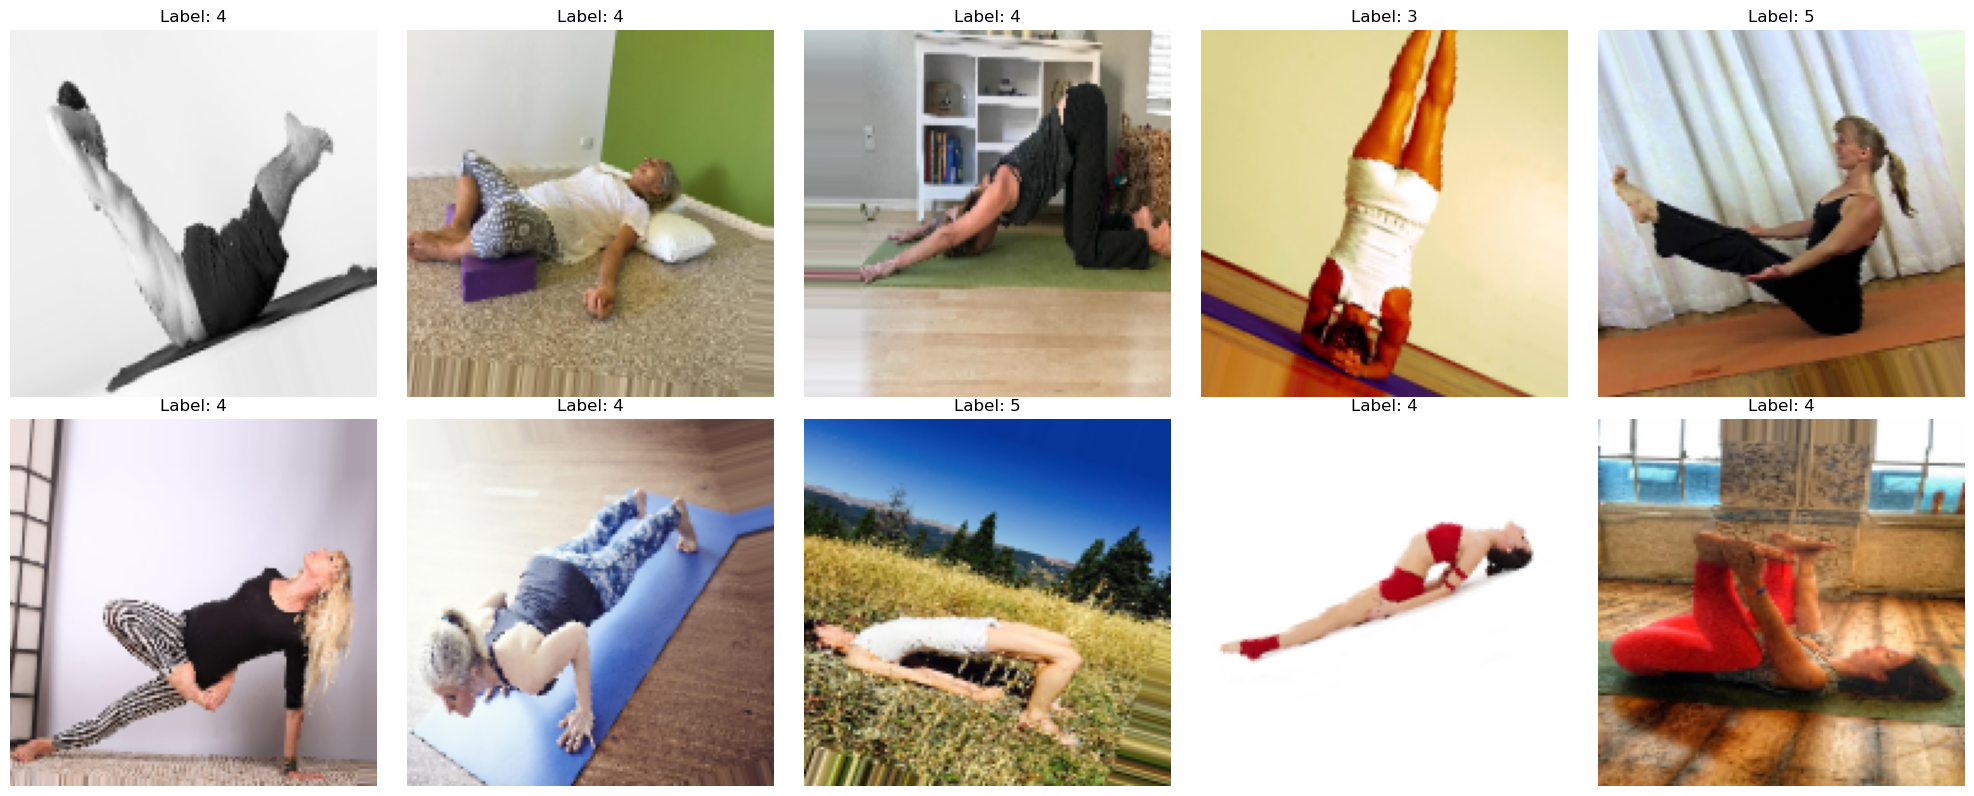

In [25]:
print(train_generator.class_indices)
num_images = 10
images_batch, labels_batch = next(train_generator)
# Set the number of rows and columns for your grid
num_rows = 2
num_cols = 5

# Increase the figure size for larger images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8)) 

batch_start_idx = train_generator.batch_index * train_generator.batch_size

for i in range(num_images):
    row_idx = i // num_cols  # Integer division to get row index
    col_idx = i % num_cols  # Remainder to get column index
    
    ax = axes[row_idx, col_idx]

    # Get image, label, and filename
    image = images_batch[i]
    label = labels_batch[i]
    # Display the image and its label
    ax.imshow(image)
    ax.set_title(f"Label: {np.argmax(label)}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
def micro_f1_score(y_true, y_pred):
    # Convert predictions to one-hot vectors
    y_pred = K.one_hot(K.argmax(y_pred), num_classes=6)

    # Calculate true positives, false positives, and false negatives over all classes
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Micro-average precision and recall
    micro_precision = K.sum(tp) / (K.sum(tp + fp) + K.epsilon())
    micro_recall = K.sum(tp) / (K.sum(tp + fn) + K.epsilon())

    # Calculate micro-averaged F1-score
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + K.epsilon())

    return micro_f1

In [28]:
model = Sequential()

# сonvolution layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flatten and use fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # 6 classes

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[micro_f1_score, 'accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[micro_f1_score, 'accuracy'])
# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 128)     

In [29]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
59/59 [==============================] - 74s 1s/step - loss: 1.7609 - micro_f1_score: 0.2421 - accuracy: 0.2421 - val_loss: 1.7273 - val_micro_f1_score: 0.2625 - val_accuracy: 0.2627
Epoch 2/20
59/59 [==============================] - 67s 1s/step - loss: 1.7313 - micro_f1_score: 0.2389 - accuracy: 0.2389 - val_loss: 1.7354 - val_micro_f1_score: 0.2625 - val_accuracy: 0.2627
Epoch 3/20
59/59 [==============================] - 71s 1s/step - loss: 1.7278 - micro_f1_score: 0.2378 - accuracy: 0.2378 - val_loss: 1.7228 - val_micro_f1_score: 0.2625 - val_accuracy: 0.2627
Epoch 4/20
59/59 [==============================] - 71s 1s/step - loss: 1.7234 - micro_f1_score: 0.2415 - accuracy: 0.2415 - val_loss: 1.7176 - val_micro_f1_score: 0.2771 - val_accuracy: 0.2775
Epoch 5/20
59/59 [==============================] - 71s 1s/step - loss: 1.7047 - micro_f1_score: 0.2786 - accuracy: 0.2786 - val_loss: 1.6866 - val_micro_f1_score: 0.2965 - val_accuracy: 0.2966
Epoch 6/20
59/59 [============

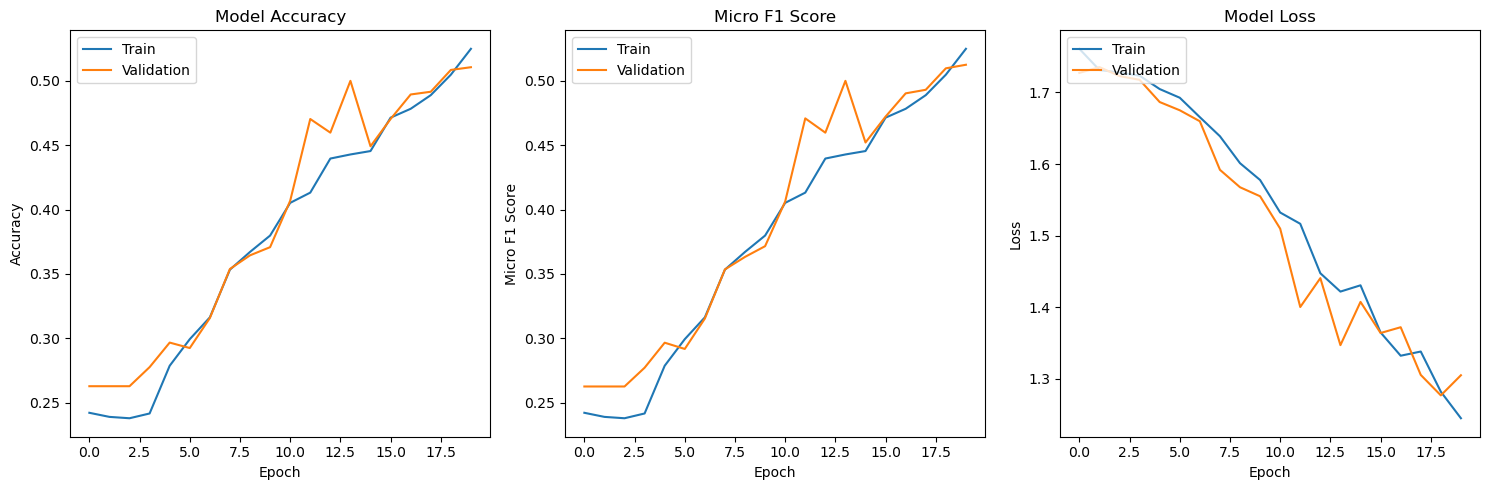

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy, F1 score, and loss values
plt.figure(figsize=(15, 5))

# Plotting Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting Micro F1 Score
plt.subplot(1, 3, 2)
plt.plot(history.history['micro_f1_score'])
plt.plot(history.history['val_micro_f1_score'])
plt.title('Micro F1 Score')
plt.ylabel('Micro F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
all_data_gen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,        # Randomly apply shear transformations
    zoom_range=0.2,         # Randomly zoom inside pictures
    fill_mode='nearest',    # The strategy used for filling in newly created pixels
    rescale=1./255,         # Rescale image values to [0,1]
)
all_data_generator = all_data_gen.flow_from_dataframe(
    dataframe=df,
    directory=url_base,
    x_col='image_id',
    y_col='class_6',
    batch_size=32,
    shuffle=False,
    class_mode='categorical',  # Use 'categorical' for one-hot encoded labels
    target_size=(150, 150)     # Adjust the target size to the size of your input images
)

Found 2360 validated image filenames belonging to 6 classes.


In [32]:
model = Sequential()

# convolution layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Flatten and use fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # 6 classes

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[micro_f1_score, 'accuracy'])

# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 11, 11, 128)     

In [33]:
# Define callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


history_all_data = model.fit(
    all_data_generator,
    epochs=50,
    steps_per_epoch=len(all_data_generator),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/50
74/74 [==============================] - 78s 1s/step - loss: 1.7576 - micro_f1_score: 0.2275 - accuracy: 0.2280
Epoch 2/50
74/74 [==============================] - 76s 1s/step - loss: 1.7352 - micro_f1_score: 0.2441 - accuracy: 0.2445
Epoch 3/50
74/74 [==============================] - 75s 1s/step - loss: 1.7274 - micro_f1_score: 0.2456 - accuracy: 0.2458
Epoch 4/50
74/74 [==============================] - 75s 1s/step - loss: 1.7040 - micro_f1_score: 0.2758 - accuracy: 0.2763
Epoch 5/50
74/74 [==============================] - 75s 1s/step - loss: 1.6837 - micro_f1_score: 0.3059 - accuracy: 0.3059
Epoch 6/50
74/74 [==============================] - 75s 1s/step - loss: 1.6564 - micro_f1_score: 0.3395 - accuracy: 0.3398
Epoch 7/50
74/74 [==============================] - 75s 1s/step - loss: 1.6176 - micro_f1_score: 0.3421 - accuracy: 0.3419
Epoch 8/50
74/74 [==============================] - 76s 1s/step - loss: 1.5836 - micro_f1_score: 0.3647 - accuracy: 0.3653
Epoch 9/50
74/74

In [34]:
test_images_dir = '/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/'
# List all the images in the test_images directory
image_filenames = os.listdir(test_images_dir)
df_test = pd.DataFrame({
    'filename': image_filenames,
    'dummy_col': [0] * len(image_filenames)  # This is a dummy column just to satisfy flow_from_dataframe
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_images_dir,
    x_col="filename",
    y_col="dummy_col",
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 756 validated image filenames.


In [35]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

756/756 [==============================] - 14s 19ms/step


In [36]:
# Extract filenames from the generator
filenames = test_generator.filenames

# Create a DataFrame
df_predictions = pd.DataFrame({
    'image_id': filenames,
    'class_6': predicted_classes
})

# If 'image_id' contains path, extract only the filename
df_predictions['image_id'] = df_predictions['image_id'].apply(lambda x: x.split('/')[-1])
df_predictions

,image_id,class_6
0,07620090bd3581a0c7c344750f18621b.jpg,3
1,277bdc60f20a49d73525ab24a6e2128a.jpg,5
2,798d7ed914181f0f61f1e84de6ae7bab.jpg,4
3,81def953c8ba1b3e084582f11972e135.jpg,4
4,772c257c9a37357eec811b923109fcb4.jpg,0
...,...,...
751,4ebf97acccead03c17d564c6701403ae.jpg,1
752,da154df9f315ce49a28d74df72c3631d.jpg,4
753,3018190bd40649434b22b57a537062f6.jpg,1
754,13189405493a419f4ad50d4066ded80b.jpg,4


In [38]:
df_predictions.to_csv('submission.csv', index=False)

In [39]:
df_predictions.head(), df_predictions.tail()

(                               image_id  class_6
 0  07620090bd3581a0c7c344750f18621b.jpg        3
 1  277bdc60f20a49d73525ab24a6e2128a.jpg        5
 2  798d7ed914181f0f61f1e84de6ae7bab.jpg        4
 3  81def953c8ba1b3e084582f11972e135.jpg        4
 4  772c257c9a37357eec811b923109fcb4.jpg        0,
                                  image_id  class_6
 751  4ebf97acccead03c17d564c6701403ae.jpg        1
 752  da154df9f315ce49a28d74df72c3631d.jpg        4
 753  3018190bd40649434b22b57a537062f6.jpg        1
 754  13189405493a419f4ad50d4066ded80b.jpg        4
 755  4f87e07026ad190722dffbd18d9f73b2.jpg        0)